# Protein folding 
Using our implementation of the AMBER forcefield for protein folding. 
Currently, it lacks water. 


## Todo 
1. GNN sims
2. CG sims
3. add water 

In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/scrap'

In [4]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
# from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

In [6]:
pf.EnergyProtein

proteinfolding.energy.EnergyProtein

In [7]:
pdb_id = '2JOF' # '5AWL'
pdb_file =  f'./{pdb_id}.pdb' # './pdb_paper/.pdb'
# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    save_dir, pdb_file_name = os.path.split(pdb_file)
    # pdb_id = pdb_file.split('/')[-1].split('.')[0]
    pdb_file = pf.download_pdb_file(pdb_id, dir = save_dir)
    
prot = pf.Protein(pdb_file)


In [8]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
#self.modeller.addSolvent(forcefield, model="tip3p", padding=.05 * nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [9]:
pdb.positions.unit

Unit({BaseUnit(base_dim=BaseDimension("length"), name="nanometer", symbol="nm"): 1.0})

In [10]:
v = pdb.positions.value_in_unit(pdb.positions.unit)

In [11]:
v = torch.tensor(v)

In [12]:
v.std(dim=0)

tensor([0.4679, 0.4441, 0.3200])

In [13]:
prot.node_positions.std(dim=0)

tensor([0.4679, 0.4441, 0.3200])

In [14]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [15]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
p_.addModel(pf.get_file_text(pdb_file), 'pdb')
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


In [17]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [39]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [40]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
pdb_energy

50957.30078125

In [41]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
initial_pos = x = prot.node_positions.to(DEVICE)

# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [42]:
h = energy_minimizer.train(10000)

Early stopping at step 6320


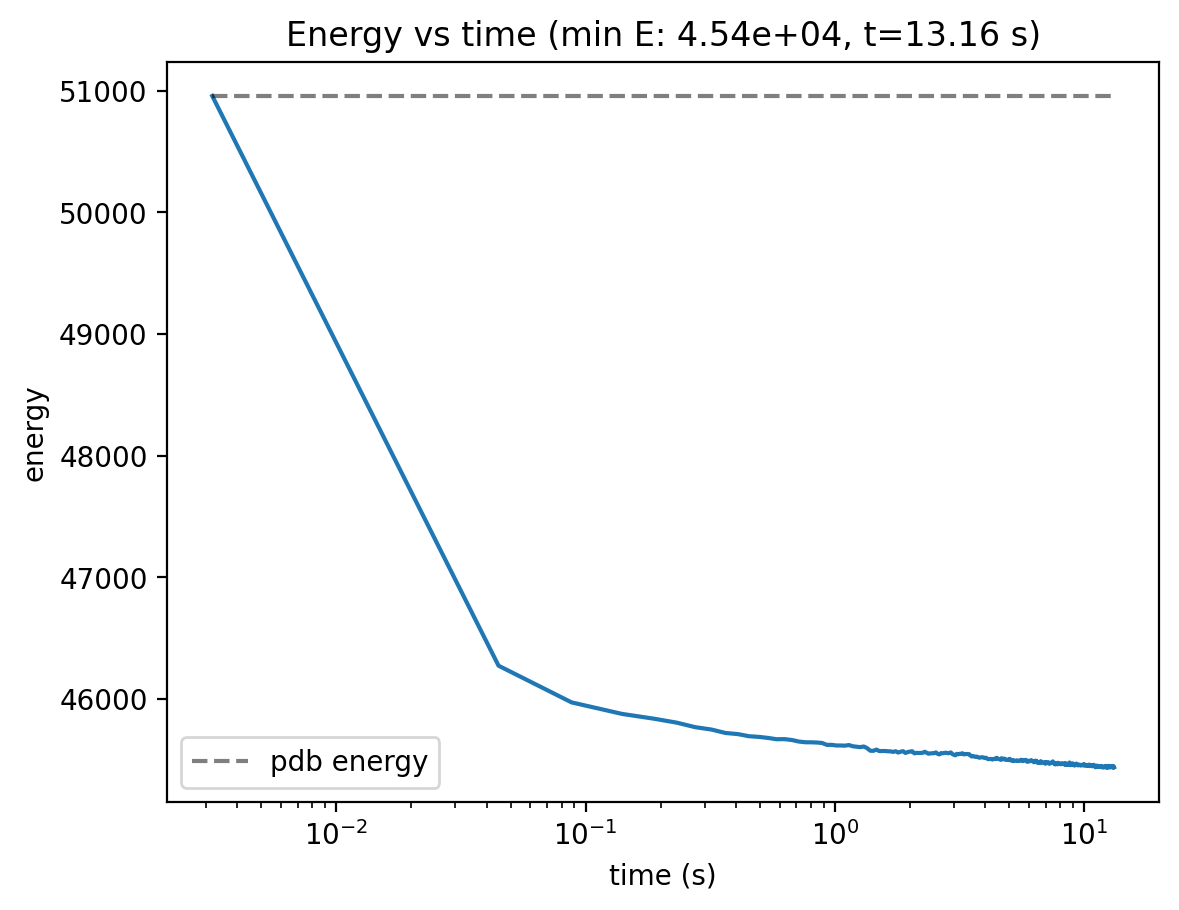

In [43]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [44]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4806, 0.4717, 0.3389], device='cuda:0', grad_fn=<StdBackward0>)

In [45]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [46]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [47]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [168]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
x = torch.randn_like(prot.node_positions)
# scale x to have std = 3*std of original positions
x = x * 1.5 * prot.node_positions.std(dim=0)
x = x.to(DEVICE)
initial_pos = x
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [169]:
# h = energy_minimizer.train(10000)

In [170]:
# len(h['time']), len(energy_minimizer.history['time'])

In [171]:
# I want to compute what my LR decay rate should be to reach a certain value after N epochs
LR = 1e-2
N = 100
LR_decay = (2e-3/LR)**(1/N)

from torch.optim.lr_scheduler import ExponentialLR

# Decay LR by a factor of 0.96 every epoch
scheduler = ExponentialLR(energy_minimizer.optimizer, gamma=LR_decay)

LR_decay

0.9840344433634576

In [224]:

for epoch in range(100):
    h = energy_minimizer.train(100)
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.4g}, time: {np.sum(h["time"]):.2f} s', end = '\r') 
    
    # Step the scheduler
    scheduler.step()
    # break

In [225]:
energy_minimizer.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 1.5999999999999823e-05
    maximize: False
    weight_decay: 0
)

Text(0.5, 1.0, 'Energy vs time (min E: 4.547e+04, t=214.75 s)')

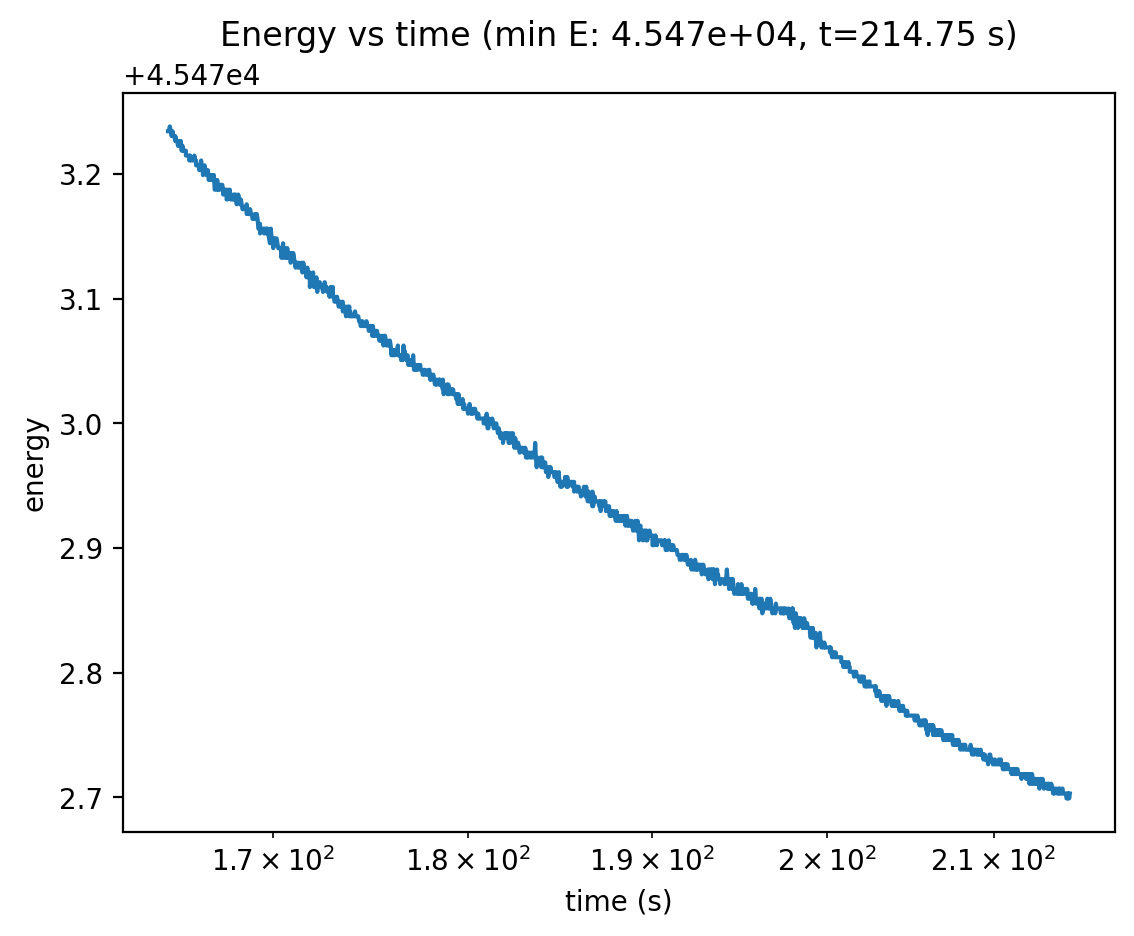

In [228]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 5000

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [229]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4783, 0.3348, 0.4746], device='cuda:0', grad_fn=<StdBackward0>)

In [230]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [231]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [232]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [110]:
# prot.harmonic_bond_data['equilibrium_length']